In [231]:
!pip install fastparquet
!pip install ipykernel
!pip install matplotlib
!pip install openpyxl
!pip install pandas
!pip install scikit-learn
!pip install scipy

pyenv: version `3.12' is not installed (set by /home/rborges/projetos/faculdade/machine-learning/trabalho-01/.python-version)
pyenv: version `3.12' is not installed (set by /home/rborges/projetos/faculdade/machine-learning/trabalho-01/.python-version)
pyenv: version `3.12' is not installed (set by /home/rborges/projetos/faculdade/machine-learning/trabalho-01/.python-version)
pyenv: version `3.12' is not installed (set by /home/rborges/projetos/faculdade/machine-learning/trabalho-01/.python-version)
pyenv: version `3.12' is not installed (set by /home/rborges/projetos/faculdade/machine-learning/trabalho-01/.python-version)
pyenv: version `3.12' is not installed (set by /home/rborges/projetos/faculdade/machine-learning/trabalho-01/.python-version)
pyenv: version `3.12' is not installed (set by /home/rborges/projetos/faculdade/machine-learning/trabalho-01/.python-version)


In [233]:
import pandas as pd

In [247]:
df = pd.read_csv("data/Metro_Interstate_Traffic_Volume.csv")

In [248]:
len(df)

48204

In [235]:
# Foram identificados alguns registros com data e hora duplicados. Foi feita a remoção das duplicatas, mantendo apenas o primeiro.
df = df[df.duplicated(subset=["date_time"]) == False]

# Tratando algumas colunas
df["weather_description"] = df["weather_description"].apply(lambda x: x.strip().lower())
df["weather_main"] = df["weather_main"].apply(lambda x: x.strip().lower())

### Remoção de outliers

Vamos verificar a incidência de valores extremos nas colunas numéricas através do `boxplot`.

<Axes: >

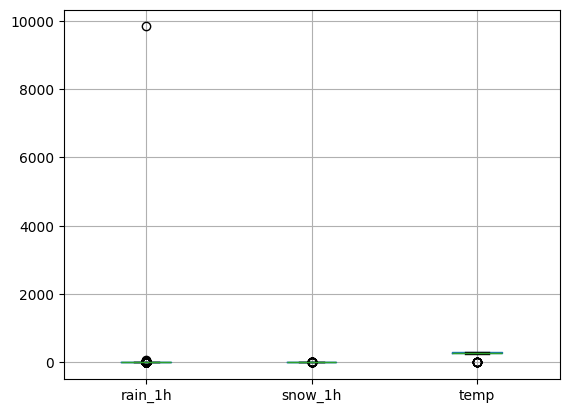

In [236]:
df[["rain_1h", "snow_1h", "temp"]].boxplot()

Através do gráfico acima, podemos observar, de maneira bastante geral, os outliers destas 3 colunas. Um valor próximo de 10000 em rain_1h, e outro próximo de 0 em temp. Como a temperatura está em Kelvin, não faz sentido um registro com temperatura tão baixa. Portanto, podemos removê-los tranquilamente.

<Axes: >

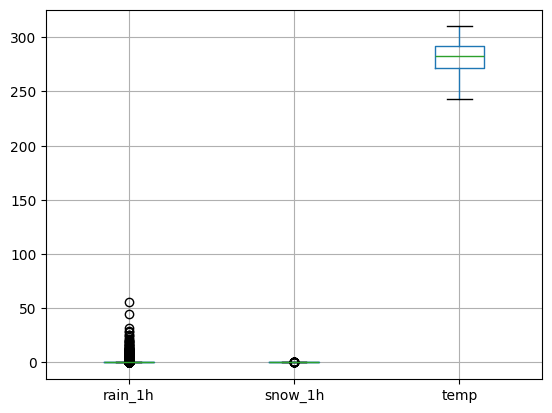

In [237]:
df_sem = df[(df.rain_1h < 8000) & (df.temp != 0)]
df_sem[["rain_1h", "snow_1h", "temp"]].boxplot()

##### **Análise individual da coluna `rain_1h`.**

A maioria dos dados desta coluna é zero, o que explica a quantidade de outliers com valores que fazem sentido, considerando a realidade da chuva. Nesse dataset, teríamos um desvio padrão grande para esses valores que, na verdade, têm sentido. Por tanto, não julguei necessário aplicar método de remoção como via z-score, por exemplo.

<Axes: >

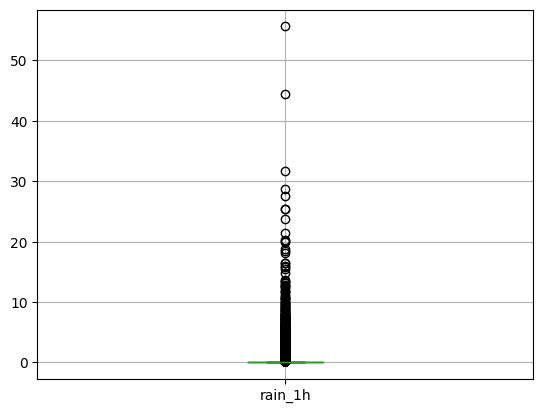

In [238]:
df_sem[["rain_1h"]].boxplot()

In [239]:
from scipy.stats import ttest_ind

# Verifiquei que alguns valores tinham a classe "Rain" mas chuva 0. Fiz um teste de significância para verificar
# se há diferença entre os dois grupos e, como não encontrei (p-value alto), optei por remover esses valores
df_tmp = df_sem[(df_sem.weather_main == "rain")]
df_tmp["rain_zero"] = df_tmp["rain_1h"] == 0

# Obtendo os valores dos dois grupos
g1 = df_tmp[df_tmp.rain_zero == True]["traffic_volume"].to_list()
g2 = df_tmp[df_tmp.rain_zero == False]["traffic_volume"].to_list()

# Aplicando o teste
res = ttest_ind(g1, g2)
print(f"{res[0]}. P-value: {res[1]}")

0.8904607297927715. P-value: 0.3732634926930595


/tmp/ipykernel_83247/968338713.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp["rain_zero"] = df_tmp["rain_1h"] == 0


In [240]:
df_sem = df_sem[~((df_sem.weather_main == "Rain") & (df_sem.rain_1h == 0))]

##### **Análise da coluna `snow_1`**

Na coluna `snow_1`, temos uma quantidade ainda maior de registros com zero neve. Vamos verificar se esses registros fazem sentido dadas suas classes.

In [241]:
df_sem[(df_sem.snow_1h != 0) & (df_sem.weather_main != "snow")]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
20158,NaN,274.33,0.98,0.51,90,rain,moderate rain,2015-12-23 12:00:00,5167


##### 2. Por classe

In [242]:
# Dado o volume de dados, é interessante remover as classes com quantidade insignificante de registros
df_sem.groupby(by="weather_main")[["rain_1h"]].count()

,rain_1h
weather_main,
clear,13356
clouds,15123
drizzle,515
fog,201
haze,766
mist,3069
rain,4768
smoke,15
snow,2297


In [243]:
df_classes = df_sem[~(df_sem.weather_main.isin(["squall", "smoke"]))]
df_classes.groupby(by="weather_main")[["rain_1h"]].count()

,rain_1h
weather_main,
clear,13356
clouds,15123
drizzle,515
fog,201
haze,766
mist,3069
rain,4768
snow,2297
thunderstorm,453


In [244]:
# Mapeando manualmente subclasses com poucos registros e valores pouco consistentes
df_classes.groupby("weather_description")[["rain_1h"]].count().reset_index()

# Removendo as subclasses
df_sub = df_classes[~(
    df_classes.weather_description.isin(
        [
            "freezing rain",
            "light rain and snow",
            "proximity thunderstorm with drizzle",
            "sleet",
            "proximity thunderstorm with rain",
            "thunderstorm with light drizzle",
        ]
    )
)]
df_final = df_sub

In [245]:
df_final.to_parquet("data/dados_tratados.parquet")

In [250]:
len(df) - len(df_final)

7676